In [2]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

In [14]:
lambda_

0.918

Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


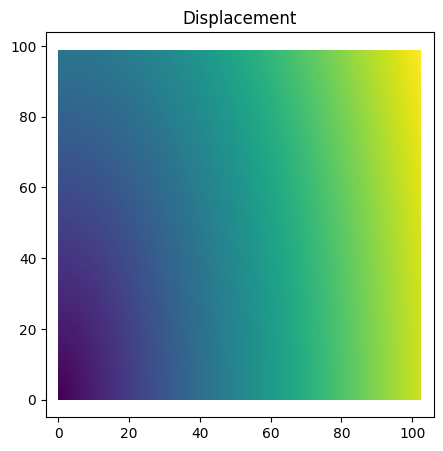

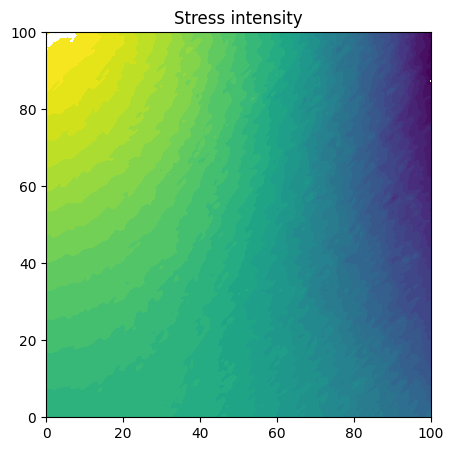

In [16]:
# Define boundary condition

C11 = np.exp(1.55)
C33 = np.exp(0.316)

pstress = 0.1
mu = C33
lambda_ = C11 - 2*C33
Lmax = Constant(100)

mesh = RectangleMesh(Point(0, 0), Point(Lmax, Lmax), 100, 100)
V = VectorFunctionSpace(mesh, 'P', 1)

tol = 1E-14

def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0, tol)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], Lmax, tol)

bc1 = DirichletBC(V.sub(0), Constant(0), left_boundary)
bc2 = DirichletBC(V.sub(1), Constant(0), bottom_boundary)
bc = [bc1, bc2]

#mark right boundary
right = AutoSubDomain(right_boundary)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
right.mark(boundaries, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
x = SpatialCoordinate(mesh)
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
# f = (0, -x[0]/Lmax)
f = Constant((0, 0))

T = Constant((pstress, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
plt.figure(figsize=(5, 5))
plot(u, title='Displacement', mode='displacement')
plt.axis('equal')

# Plot stress
stress = sigma(u) 
tensor_space = TensorFunctionSpace(mesh, 'P', 1)
stress = project(sigma(u), tensor_space)
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
plt.figure(figsize=(5, 5))
plot(von_Mises, title='Stress intensity')




# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, V)



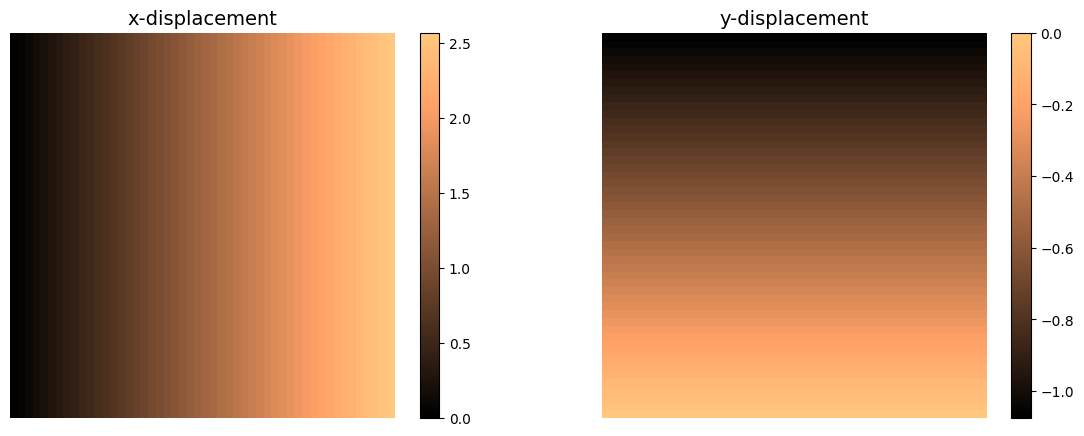

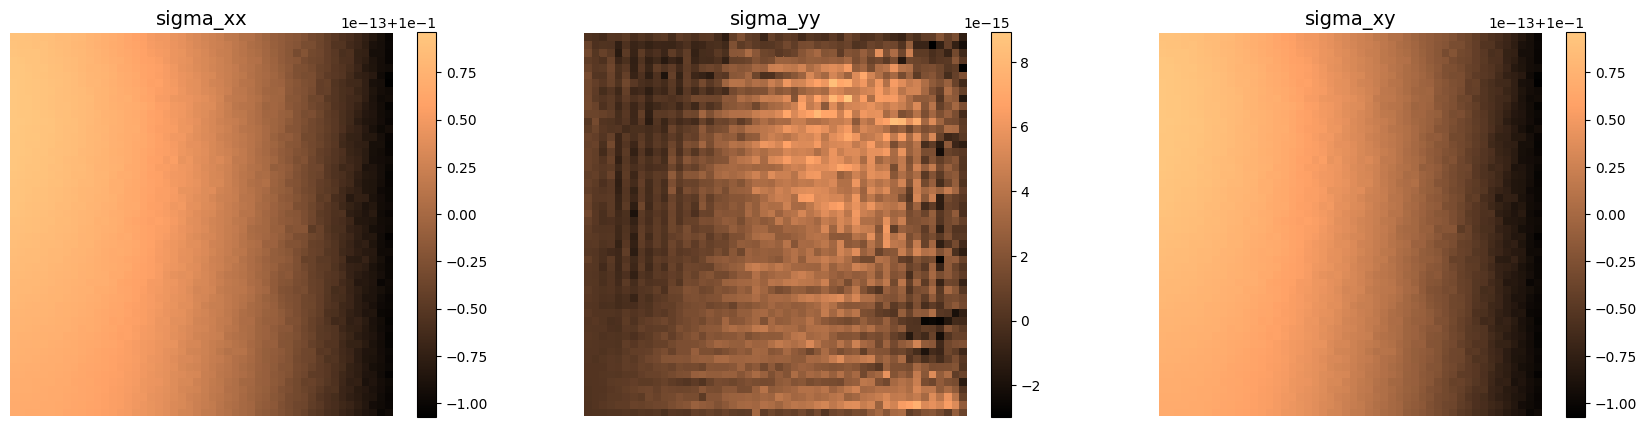

In [17]:
from scipy.interpolate import griddata

def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'off',**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)
    return im

def create_regular_grid(coordinates, u_values, grid_res=50):
    # Create a regular grid
    x_min, y_min = np.min(coordinates, axis=0)
    x_max, y_max = np.max(coordinates, axis=0)
    grid_x, grid_y = np.mgrid[x_min:x_max:complex(grid_res), y_min:y_max:complex(grid_res)]

    # Interpolate unstructured data to the regular grid
    grid_u_values = griddata(coordinates, u_values, (grid_x, grid_y), method='cubic')
    
    return grid_x, grid_y, grid_u_values

# Extract vertex coordinates and displacement values
coordinates = mesh.coordinates()
u_values = u.compute_vertex_values(mesh)
s_xx = stress.sub(0, 0).compute_vertex_values(mesh)  # Sigma_xx
s_yy = stress.sub(1, 1).compute_vertex_values(mesh)  # Sigma_yy
s_xy = stress.sub(0, 1).compute_vertex_values(mesh)  # Sigma_xy

# Reshape displacement to have 2 components
u_values = u_values.reshape((2, -1))
for s in [s_xx, s_yy, s_xy]:
    s = s.reshape((1, -1))
# Interpolate data onto a regular grid
grid_x, grid_y, grid_u_x = create_regular_grid(coordinates, u_values[0, :])
_, _, grid_u_y = create_regular_grid(coordinates, u_values[1, :])
_, _, grid_s_xx = create_regular_grid(coordinates, s_xx)
_, _, grid_s_yy = create_regular_grid(coordinates, s_yy)
_, _, grid_s_xy = create_regular_grid(coordinates, s_xy)

# Plot displacement
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im = pcolor_plot(ax[0], grid_x, grid_y, grid_u_x, "x-displacement")
fig.colorbar(im, ax=ax[0])
im = pcolor_plot(ax[1], grid_x, grid_y, grid_u_y, "y-displacement")
fig.colorbar(im, ax=ax[1])

# Plot stress
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
im = pcolor_plot(ax[0], grid_x, grid_y, grid_s_xx, "sigma_xx")
fig.colorbar(im, ax=ax[0])
im = pcolor_plot(ax[1], grid_x, grid_y, grid_s_yy, "sigma_yy")
fig.colorbar(im, ax=ax[1])
im = pcolor_plot(ax[2], grid_x, grid_y, grid_s_xy, "sigma_xy")
fig.colorbar(im, ax=ax[2])


plt.show()
